## Hybrid method: Recursive feature elimination

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [81]:
data = pd.read_csv('../DoHBrwTest.csv')
data.shape

(53860, 35)

In [66]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,is_intrusion
0,7.0,2.0,52742,443,18355.0,0.046455,55,1183.941449,66,1420.729738,...,1.000000,0.000000,0.000000,0.046455,0.046455,0.046455,-10.000000,-10.000000,0.000000,0
1,7.0,2.0,54640,443,18365.0,96.750105,42044,434.562836,44920,464.288902,...,0.561877,0.001700,0.041234,0.033549,0.026931,0.026952,0.481463,0.159978,1.229096,0
2,7.0,2.0,56611,443,18373.0,96.365606,41539,431.056284,44577,462.582054,...,0.549156,0.000956,0.030926,0.026551,0.026848,0.026879,-0.028834,-0.010614,1.164778,0
3,7.0,2.0,56611,443,18374.0,121.356820,60659,499.840058,67897,559.482360,...,0.556570,0.001013,0.031829,0.027571,0.026862,0.026941,0.066819,0.019791,1.154439,0
4,7.0,2.0,56611,443,18375.0,104.669253,30409,290.524668,30718,293.476825,...,0.331633,0.001226,0.035013,0.029797,0.026867,0.026908,0.251063,0.082517,1.175049,0


### Train - Test Split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.4,
    random_state=10)

X_train.shape, X_test.shape

((32316, 34), (21544, 34))

### Remove constant and quasi-constant features

In [68]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.85:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((32316, 33), (21544, 33))

### Remove duplicated features

In [69]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30


0

In [70]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((32316, 33), (21544, 33))

### Build ML model with all features

In [71]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=1.000000


### Rank features by importance

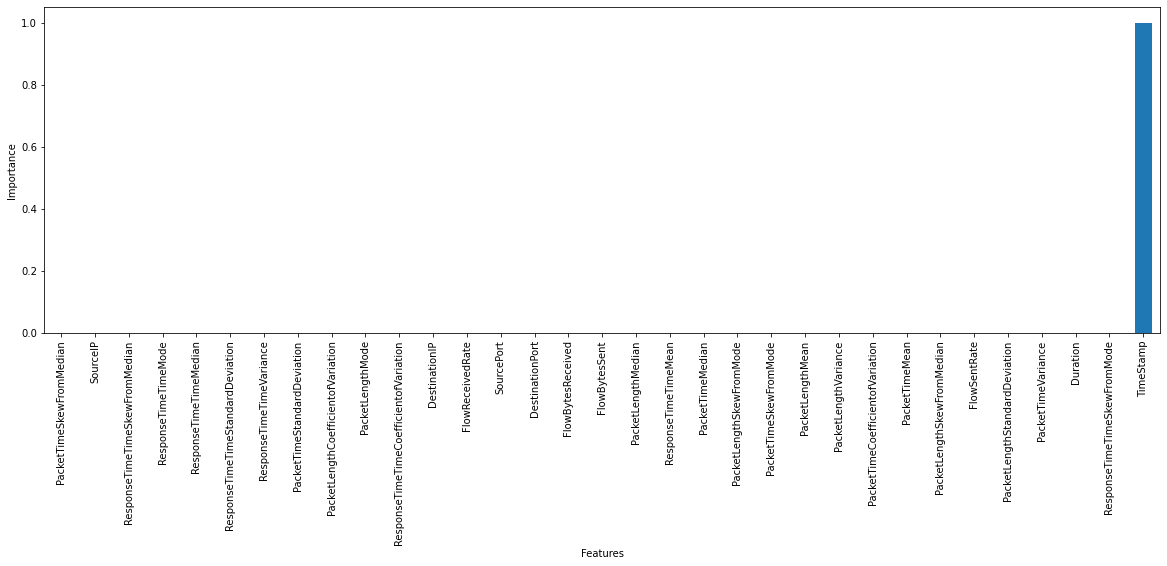

In [72]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [73]:
# make list of ordered features
features = list(features.index)
features

['PacketTimeSkewFromMedian',
 'SourceIP',
 'ResponseTimeTimeSkewFromMedian',
 'ResponseTimeTimeMode',
 'ResponseTimeTimeMedian',
 'ResponseTimeTimeStandardDeviation',
 'ResponseTimeTimeVariance',
 'PacketTimeStandardDeviation',
 'PacketLengthCoefficientofVariation',
 'PacketLengthMode',
 'ResponseTimeTimeCoefficientofVariation',
 'DestinationIP',
 'FlowReceivedRate',
 'SourcePort',
 'DestinationPort',
 'FlowBytesReceived',
 'FlowBytesSent',
 'PacketLengthMedian',
 'ResponseTimeTimeMean',
 'PacketTimeMedian',
 'PacketLengthSkewFromMode',
 'PacketTimeSkewFromMode',
 'PacketLengthMean',
 'PacketLengthVariance',
 'PacketTimeCoefficientofVariation',
 'PacketTimeMean',
 'PacketLengthSkewFromMedian',
 'FlowSentRate',
 'PacketLengthStandardDeviation',
 'PacketTimeVariance',
 'Duration',
 'ResponseTimeTimeSkewFromMode',
 'TimeStamp']

### Select features

In [75]:
# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold, the feature will be removed
from sklearn import linear_model

tol = 0.0001

print('doing recursive feature elimination')

# we initialise a list where we will collect the features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = linear_model.LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to remove: ', len(features_to_remove), )

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

# Sit back and relax, this will take a while!

doing recursive feature elimination

testing feature:  PacketTimeSkewFromMedian 1  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999689160353452
Full dataset ROC AUC=1.0
Drop in ROC AUC=3.10839646547878e-05
remove:  PacketTimeSkewFromMedian

testing feature:  SourceIP 2  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999527090726793
Full dataset ROC AUC=0.9999689160353452
Drop in ROC AUC=1.620696266591004e-05
remove:  SourceIP

testing feature:  ResponseTimeTimeSkewFromMedian 3  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.999968328378302
Full dataset ROC AUC=0.9999527090726793
Drop in ROC AUC=-1.5619305622660562e-05
remove:  ResponseTimeTimeSkewFromMedian

testing feature:  ResponseTimeTimeMode 4  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999673077108059
Full dataset ROC AUC=0.999968328378302
Drop in ROC AUC=1.0206674960766549e-06
remove:  ResponseTimeTimeMode

testing feature:  ResponseTimeTimeMedian 5  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999715450273806
Full dataset ROC AUC=0.9999673077108059
Drop in ROC AUC=-4.237316574728922e-06
remove:  ResponseTimeTimeMedian

testing feature:  ResponseTimeTimeStandardDeviation 6  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999697820562509
Full dataset ROC AUC=0.9999715450273806
Drop in ROC AUC=1.7629711297484363e-06
remove:  ResponseTimeTimeStandardDeviation

testing feature:  ResponseTimeTimeVariance 7  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999533276590407
Full dataset ROC AUC=0.9999697820562509
Drop in ROC AUC=1.645439721020825e-05
remove:  ResponseTimeTimeVariance

testing feature:  PacketTimeStandardDeviation 8  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999704934305665
Full dataset ROC AUC=0.9999533276590407
Drop in ROC AUC=-1.7165771525884388e-05
remove:  PacketTimeStandardDeviation

testing feature:  PacketLengthCoefficientofVariation 9  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999708027237469
Full dataset ROC AUC=0.9999704934305665
Drop in ROC AUC=-3.092931804005161e-07
remove:  PacketLengthCoefficientofVariation

testing feature:  PacketLengthMode 10  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999601321090149
Full dataset ROC AUC=0.9999708027237469
Drop in ROC AUC=1.0670614732033457e-05
remove:  PacketLengthMode

testing feature:  ResponseTimeTimeCoefficientofVariation 11  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999579051981141
Full dataset ROC AUC=0.9999601321090149
Drop in ROC AUC=2.2269109007932997e-06
remove:  ResponseTimeTimeCoefficientofVariation

testing feature:  DestinationIP 12  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999580907740225
Full dataset ROC AUC=0.9999579051981141
Drop in ROC AUC=-1.8557590841794536e-07
remove:  DestinationIP

testing feature:  FlowReceivedRate 13  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999522760622265
Full dataset ROC AUC=0.9999580907740225
Drop in ROC AUC=5.814711796059413e-06
remove:  FlowReceivedRate

testing feature:  SourcePort 14  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9973746885533656
Full dataset ROC AUC=0.9999522760622265
Drop in ROC AUC=0.0025775875088608347
keep:  SourcePort

testing feature:  DestinationPort 15  out of  33
New Test ROC AUC=0.9993539174749502
Full dataset ROC AUC=0.9999522760622265
Drop in ROC AUC=0.0005983585872763042
keep:  DestinationPort

testing feature:  FlowBytesReceived 16  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999927316102548
Full dataset ROC AUC=0.9999522760622265
Drop in ROC AUC=-4.045554802833973e-05
remove:  FlowBytesReceived

testing feature:  FlowBytesSent 17  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999717615326071
Full dataset ROC AUC=0.9999927316102548
Drop in ROC AUC=2.097007764767511e-05
remove:  FlowBytesSent

testing feature:  PacketLengthMedian 18  out of  33
New Test ROC AUC=0.9999540699626742
Full dataset ROC AUC=0.9999717615326071
Drop in ROC AUC=1.7691569932920537e-05
remove:  PacketLengthMedian

testing feature:  ResponseTimeTimeMean 19  out of  33
New Test ROC AUC=0.9999545648317633
Full dataset ROC AUC=0.9999540699626742
Drop in ROC AUC=-4.948690890405061e-07
remove:  ResponseTimeTimeMean

testing feature:  PacketTimeMedian 20  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999534204469949
Full dataset ROC AUC=0.9999545648317633
Drop in ROC AUC=1.1443847683922925e-06
remove:  PacketTimeMedian

testing feature:  PacketLengthSkewFromMode 21  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.9999531730124503
Full dataset ROC AUC=0.9999534204469949
Drop in ROC AUC=2.4743454452025304e-07
remove:  PacketLengthSkewFromMode

testing feature:  PacketTimeSkewFromMode 22  out of  33


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


New Test ROC AUC=0.999952059557
Full dataset ROC AUC=0.9999531730124503
Drop in ROC AUC=1.1134554503966498e-06
remove:  PacketTimeSkewFromMode

testing feature:  PacketLengthMean 23  out of  33
New Test ROC AUC=0.9999355742304716
Full dataset ROC AUC=0.999952059557
Drop in ROC AUC=1.6485326528314914e-05
remove:  PacketLengthMean

testing feature:  PacketLengthVariance 24  out of  33
New Test ROC AUC=0.9999363783927413
Full dataset ROC AUC=0.9999355742304716
Drop in ROC AUC=-8.041622696630668e-07
remove:  PacketLengthVariance

testing feature:  PacketTimeCoefficientofVariation 25  out of  33
New Test ROC AUC=0.9999359763116064
Full dataset ROC AUC=0.9999363783927413
Drop in ROC AUC=4.020811349425557e-07
remove:  PacketTimeCoefficientofVariation

testing feature:  PacketTimeMean 26  out of  33
New Test ROC AUC=0.9999254294141464
Full dataset ROC AUC=0.9999359763116064
Drop in ROC AUC=1.0546897459939863e-05
remove:  PacketTimeMean

testing feature:  PacketLengthSkewFromMedian 27  out of  

In [76]:
features_to_remove

['PacketTimeSkewFromMedian',
 'SourceIP',
 'ResponseTimeTimeSkewFromMedian',
 'ResponseTimeTimeMode',
 'ResponseTimeTimeMedian',
 'ResponseTimeTimeStandardDeviation',
 'ResponseTimeTimeVariance',
 'PacketTimeStandardDeviation',
 'PacketLengthCoefficientofVariation',
 'PacketLengthMode',
 'ResponseTimeTimeCoefficientofVariation',
 'DestinationIP',
 'FlowReceivedRate',
 'FlowBytesReceived',
 'FlowBytesSent',
 'PacketLengthMedian',
 'ResponseTimeTimeMean',
 'PacketTimeMedian',
 'PacketLengthSkewFromMode',
 'PacketTimeSkewFromMode',
 'PacketLengthMean',
 'PacketLengthVariance',
 'PacketTimeCoefficientofVariation',
 'PacketTimeMean',
 'PacketLengthSkewFromMedian',
 'FlowSentRate',
 'PacketLengthStandardDeviation',
 'PacketTimeVariance',
 'Duration',
 'ResponseTimeTimeSkewFromMode']

In [77]:
# for comparison, building a model with the selected features only

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=1.000000


The Gradient Boosting model built with 6 features shows a similar performance than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).

In [78]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [79]:
X_train.shape, X_test.shape

((32316, 3), (21544, 3))

## Standardize Data





In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers




In [18]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation




In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [21]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1).fit(X_train, y_train)

CPU times: user 66.1 ms, sys: 188 ms, total: 254 ms
Wall time: 1.5 s


In [22]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.828974002778329
F1 Score: 0.8137131987376248
FPR: 0.1496220542463317
TPR: 0.8042902316041364


### Naive Bayes





In [23]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-09).fit(X_train, y_train)

CPU times: user 18.1 ms, sys: 3.68 ms, total: 21.7 ms
Wall time: 19.8 ms


In [24]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.4336574717205795
F1 Score: 0.5898416166029492
FPR: 0.9506447309915518
TPR: 0.876848132638236


### Random Forest




In [25]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 4.04 s, sys: 73.2 ms, total: 4.12 s
Wall time: 4.12 s


In [26]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5155784877951974
F1 Score: 0.37169067841937425
FPR: 0.04557581147176523
TPR: 0.009486368686437057


### KNN



In [27]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance').fit(X_train, y_train)

CPU times: user 6.13 ms, sys: 1.45 ms, total: 7.58 ms
Wall time: 5.77 ms


In [28]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.2013891645167692
f1: 0.2978188797766533
fpr: 0.9401956425077812
tpr: 0.36466968635159386


### CatBoost





In [29]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6571031	total: 62ms	remaining: 3.04s
1:	learn: 0.6236993	total: 69.2ms	remaining: 1.66s
2:	learn: 0.5933681	total: 75.8ms	remaining: 1.19s
3:	learn: 0.5639554	total: 83.5ms	remaining: 960ms
4:	learn: 0.5367737	total: 90.4ms	remaining: 814ms
5:	learn: 0.5114499	total: 96.8ms	remaining: 710ms
6:	learn: 0.4878632	total: 104ms	remaining: 640ms
7:	learn: 0.4666128	total: 111ms	remaining: 583ms
8:	learn: 0.4457012	total: 118ms	remaining: 536ms
9:	learn: 0.4256227	total: 124ms	remaining: 497ms
10:	learn: 0.4073112	total: 131ms	remaining: 465ms
11:	learn: 0.3902414	total: 138ms	remaining: 438ms
12:	learn: 0.3740821	total: 146ms	remaining: 414ms
13:	learn: 0.3587523	total: 152ms	remaining: 392ms
14:	learn: 0.3440923	total: 159ms	remaining: 371ms
15:	learn: 0.3302482	total: 165ms	remaining: 352ms
16:	learn: 0.3170765	total: 172ms	remaining: 335ms
17:	learn: 0.3049327	total: 179ms	remaining: 318ms
18:	learn: 0.2934050	total: 186ms	remaining: 303ms
19:	learn: 0.2821617	total: 193ms	rem

In [30]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5368922405239135
F1 Score: 0.39322502459172953
FPR: 0.018452645620275678
TPR: 0.024100504230407657


## Model Evaluation




In [31]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../KDDTest.csv")
test_df.shape

(22543, 42)

In [33]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [34]:
X_eval = X_eval[features_to_keep]

In [35]:
X_eval.shape

(22543, 6)

### Model Evaluation - Logistic Regression




In [36]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1, random_state=42)

In [37]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [38]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.89683161832561
Testing accuracy is  0.828974002778329


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.828974002778329
F1 Score: 0.8137131987376248
Precision Score: 0.8233595800524934
Recall Score: 0.8042902316041364
Confusion Matrix:
 [[11475  2019]
 [ 2290  9411]]


### Cross validation - Logistic Regression




In [40]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.78983 (+/- 0.04233)
F1 Score: 0.80985 (+/- 0.04005)
Precision: 0.83452 (+/- 0.03670)
Recall: 0.78686 (+/- 0.05130)


### Model Evaluation - Naive Bayes




In [41]:
modelNB = GaussianNB(var_smoothing=1e-09)
modelNB.fit(X_train, y_train)

GaussianNB()

In [42]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [43]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.6953471526241106
Testing accuracy is  0.4336574717205795


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))


Performance measures for test:
--------
Accuracy: 0.4336574717205795
F1 Score: 0.5898416166029492
Precision Score: 0.44438669438669437
Recall Score: 0.876848132638236
Confusion Matrix:
 [[  666 12828]
 [ 1441 10260]]


### Cross validation - Naive Bayes




In [45]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.76711 (+/- 0.01969)
F1 Score: 0.77929 (+/- 0.02232)
Precision: 0.84584 (+/- 0.01934)
Recall: 0.72273 (+/- 0.03671)


### Model Evaluation - Random Forest





In [46]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [47]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [48]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.9983230300564613
Testing accuracy is  0.5155784877951974


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.5155784877951974
F1 Score: 0.37169067841937425
Precision Score: 0.3529041637205031
Recall Score: 0.5155784877951974
Confusion Matrix:
 [[12879   615]
 [11590   111]]


### Cross validation - Random Forest





In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98288 (+/- 0.00510)
F1 Score: 0.98497 (+/- 0.00449)
Precision: 0.98452 (+/- 0.00618)
Recall: 0.98543 (+/- 0.00683)


### Model Evaluation - KNN





In [51]:
modelKNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=2,
                     weights='distance')

In [52]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [53]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.995951457177729
Testing accuracy is  0.2013891645167692


In [54]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.2013891645167692
F1 Score: 0.2978188797766533
Precision Score: 0.25168101922850067
Recall Score: 0.36466968635159386
Confusion Matrix:
 [[  807 12687]
 [ 7434  4267]]


### Cross validation - KNN




In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.97192 (+/- 0.00735)
F1 Score: 0.97534 (+/- 0.00645)
Precision: 0.97508 (+/- 0.00748)
Recall: 0.97561 (+/- 0.00785)


### Model Evaluation - CatBoost





In [56]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6571031	total: 7.29ms	remaining: 357ms
1:	learn: 0.6236993	total: 13.9ms	remaining: 334ms
2:	learn: 0.5933681	total: 20.6ms	remaining: 323ms
3:	learn: 0.5639554	total: 27ms	remaining: 311ms
4:	learn: 0.5367737	total: 33.7ms	remaining: 303ms
5:	learn: 0.5114499	total: 40.2ms	remaining: 295ms
6:	learn: 0.4878632	total: 47.6ms	remaining: 293ms
7:	learn: 0.4666128	total: 53.8ms	remaining: 282ms
8:	learn: 0.4457012	total: 60.2ms	remaining: 274ms
9:	learn: 0.4256227	total: 66.3ms	remaining: 265ms
10:	learn: 0.4073112	total: 72.9ms	remaining: 258ms
11:	learn: 0.3902414	total: 79.3ms	remaining: 251ms
12:	learn: 0.3740821	total: 85.7ms	remaining: 244ms
13:	learn: 0.3587523	total: 92ms	remaining: 236ms
14:	learn: 0.3440923	total: 98.3ms	remaining: 229ms
15:	learn: 0.3302482	total: 105ms	remaining: 223ms
16:	learn: 0.3170765	total: 111ms	remaining: 216ms
17:	learn: 0.3049327	total: 118ms	remaining: 209ms
18:	learn: 0.2934050	total: 124ms	remaining: 202ms
19:	learn: 0.2821617	total: 13

In [57]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [58]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9868620816257678
Testing accuracy is  0.5368922405239135


In [59]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.5368922405239135
F1 Score: 0.39322502459172953
Precision Score: 0.5342569854488287
Recall Score: 0.5368922405239135
Confusion Matrix:
 [[13245   249]
 [11419   282]]


### Cross validation - CatBoost





In [60]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6622052	total: 3.87ms	remaining: 189ms
1:	learn: 0.6325089	total: 7.65ms	remaining: 184ms
2:	learn: 0.6050407	total: 11.5ms	remaining: 180ms
3:	learn: 0.5800682	total: 15.4ms	remaining: 177ms
4:	learn: 0.5568161	total: 19.4ms	remaining: 174ms
5:	learn: 0.5346816	total: 23.3ms	remaining: 171ms
6:	learn: 0.5137615	total: 27.1ms	remaining: 166ms
7:	learn: 0.4946974	total: 30.9ms	remaining: 162ms
8:	learn: 0.4763106	total: 35ms	remaining: 159ms
9:	learn: 0.4586227	total: 38.8ms	remaining: 155ms
10:	learn: 0.4425415	total: 42.5ms	remaining: 151ms
11:	learn: 0.4271695	total: 46.5ms	remaining: 147ms
12:	learn: 0.4128098	total: 50.4ms	remaining: 143ms
13:	learn: 0.3990125	total: 54.2ms	remaining: 139ms
14:	learn: 0.3857839	total: 58ms	remaining: 135ms
15:	learn: 0.3738927	total: 61.8ms	remaining: 131ms
16:	learn: 0.3622906	total: 65.7ms	remaining: 128ms
17:	learn: 0.3503503	total: 69.7ms	remaining: 124ms
18:	learn: 0.3400523	total: 73.6ms	remaining: 120ms
19:	learn: 0.3298621	total

20:	learn: 0.3222305	total: 81.4ms	remaining: 112ms
21:	learn: 0.3136871	total: 85.1ms	remaining: 108ms
22:	learn: 0.3051144	total: 88.7ms	remaining: 104ms
23:	learn: 0.2964664	total: 92.4ms	remaining: 100ms
24:	learn: 0.2889072	total: 95.9ms	remaining: 95.9ms
25:	learn: 0.2814052	total: 99.6ms	remaining: 91.9ms
26:	learn: 0.2742419	total: 103ms	remaining: 87.9ms
27:	learn: 0.2675240	total: 107ms	remaining: 83.9ms
28:	learn: 0.2604349	total: 110ms	remaining: 79.9ms
29:	learn: 0.2542479	total: 114ms	remaining: 76ms
30:	learn: 0.2483920	total: 118ms	remaining: 72.4ms
31:	learn: 0.2424290	total: 122ms	remaining: 68.6ms
32:	learn: 0.2367008	total: 126ms	remaining: 64.7ms
33:	learn: 0.2312275	total: 129ms	remaining: 60.9ms
34:	learn: 0.2262785	total: 133ms	remaining: 57.1ms
35:	learn: 0.2217010	total: 137ms	remaining: 53.2ms
36:	learn: 0.2169447	total: 141ms	remaining: 49.4ms
37:	learn: 0.2123259	total: 145ms	remaining: 45.7ms
38:	learn: 0.2079937	total: 148ms	remaining: 41.9ms
39:	learn: 0

0:	learn: 0.6625349	total: 3.64ms	remaining: 178ms
1:	learn: 0.6328683	total: 7.41ms	remaining: 178ms
2:	learn: 0.6063274	total: 11.6ms	remaining: 182ms
3:	learn: 0.5803726	total: 15.3ms	remaining: 176ms
4:	learn: 0.5570513	total: 19.2ms	remaining: 173ms
5:	learn: 0.5351604	total: 23.2ms	remaining: 170ms
6:	learn: 0.5148697	total: 27ms	remaining: 166ms
7:	learn: 0.4956820	total: 31.1ms	remaining: 163ms
8:	learn: 0.4772192	total: 35.1ms	remaining: 160ms
9:	learn: 0.4603119	total: 39ms	remaining: 156ms
10:	learn: 0.4437106	total: 42.9ms	remaining: 152ms
11:	learn: 0.4284740	total: 46.7ms	remaining: 148ms
12:	learn: 0.4137247	total: 50.5ms	remaining: 144ms
13:	learn: 0.3997765	total: 54.2ms	remaining: 139ms
14:	learn: 0.3863924	total: 58.3ms	remaining: 136ms
15:	learn: 0.3739415	total: 61.9ms	remaining: 132ms
16:	learn: 0.3622835	total: 65.7ms	remaining: 128ms
17:	learn: 0.3510736	total: 69.6ms	remaining: 124ms
18:	learn: 0.3402392	total: 73.3ms	remaining: 120ms
19:	learn: 0.3304784	total

0:	learn: 0.6621468	total: 3.65ms	remaining: 179ms
1:	learn: 0.6338229	total: 7.33ms	remaining: 176ms
2:	learn: 0.6072997	total: 11ms	remaining: 173ms
3:	learn: 0.5817130	total: 14.9ms	remaining: 171ms
4:	learn: 0.5581132	total: 19.4ms	remaining: 175ms
5:	learn: 0.5362954	total: 23.5ms	remaining: 172ms
6:	learn: 0.5159371	total: 27.4ms	remaining: 168ms
7:	learn: 0.4967253	total: 31.1ms	remaining: 163ms
8:	learn: 0.4776341	total: 34.9ms	remaining: 159ms
9:	learn: 0.4603368	total: 38.7ms	remaining: 155ms
10:	learn: 0.4441108	total: 42.6ms	remaining: 151ms
11:	learn: 0.4285954	total: 46.4ms	remaining: 147ms
12:	learn: 0.4139491	total: 50.4ms	remaining: 143ms
13:	learn: 0.4001051	total: 54.3ms	remaining: 140ms
14:	learn: 0.3867440	total: 58.1ms	remaining: 136ms
15:	learn: 0.3743216	total: 61.9ms	remaining: 132ms
16:	learn: 0.3627973	total: 65.8ms	remaining: 128ms
17:	learn: 0.3517411	total: 69.8ms	remaining: 124ms
18:	learn: 0.3409997	total: 73.7ms	remaining: 120ms
19:	learn: 0.3309501	tot

0:	learn: 0.6620366	total: 4.02ms	remaining: 197ms
1:	learn: 0.6336641	total: 7.9ms	remaining: 190ms
2:	learn: 0.6073197	total: 11.6ms	remaining: 181ms
3:	learn: 0.5822059	total: 15.3ms	remaining: 176ms
4:	learn: 0.5589769	total: 19.3ms	remaining: 173ms
5:	learn: 0.5373236	total: 23.4ms	remaining: 172ms
6:	learn: 0.5163097	total: 27.3ms	remaining: 167ms
7:	learn: 0.4972498	total: 31.1ms	remaining: 163ms
8:	learn: 0.4781305	total: 35ms	remaining: 160ms
9:	learn: 0.4605261	total: 38.7ms	remaining: 155ms
10:	learn: 0.4440298	total: 42.7ms	remaining: 151ms
11:	learn: 0.4287524	total: 46.5ms	remaining: 147ms
12:	learn: 0.4139855	total: 50.4ms	remaining: 144ms
13:	learn: 0.4001726	total: 54.1ms	remaining: 139ms
14:	learn: 0.3866455	total: 57.9ms	remaining: 135ms
15:	learn: 0.3742121	total: 61.7ms	remaining: 131ms
16:	learn: 0.3626935	total: 65.8ms	remaining: 128ms
17:	learn: 0.3515570	total: 69.7ms	remaining: 124ms
18:	learn: 0.3407403	total: 73.8ms	remaining: 120ms
19:	learn: 0.3309587	tota

0:	learn: 0.6625297	total: 3.61ms	remaining: 177ms
1:	learn: 0.6332727	total: 7.44ms	remaining: 179ms
2:	learn: 0.6062924	total: 11.1ms	remaining: 174ms
3:	learn: 0.5813162	total: 14.9ms	remaining: 171ms
4:	learn: 0.5580633	total: 18.6ms	remaining: 168ms
5:	learn: 0.5359094	total: 22.4ms	remaining: 165ms
6:	learn: 0.5154266	total: 26.2ms	remaining: 161ms
7:	learn: 0.4961979	total: 29.8ms	remaining: 156ms
8:	learn: 0.4776523	total: 33.7ms	remaining: 153ms
9:	learn: 0.4612352	total: 37.3ms	remaining: 149ms
10:	learn: 0.4447394	total: 41.2ms	remaining: 146ms
11:	learn: 0.4294261	total: 45.4ms	remaining: 144ms
12:	learn: 0.4145841	total: 49.2ms	remaining: 140ms
13:	learn: 0.4008620	total: 53.2ms	remaining: 137ms
14:	learn: 0.3878636	total: 57ms	remaining: 133ms
15:	learn: 0.3764602	total: 60.8ms	remaining: 129ms
16:	learn: 0.3646017	total: 64.5ms	remaining: 125ms
17:	learn: 0.3532409	total: 68.2ms	remaining: 121ms
18:	learn: 0.3421392	total: 72.3ms	remaining: 118ms
19:	learn: 0.3323229	tot

0:	learn: 0.6613829	total: 3.7ms	remaining: 181ms
1:	learn: 0.6334350	total: 7.7ms	remaining: 185ms
2:	learn: 0.6069002	total: 11.4ms	remaining: 179ms
3:	learn: 0.5809908	total: 15.1ms	remaining: 174ms
4:	learn: 0.5576267	total: 19.2ms	remaining: 172ms
5:	learn: 0.5357593	total: 22.8ms	remaining: 167ms
6:	learn: 0.5148162	total: 26.7ms	remaining: 164ms
7:	learn: 0.4956551	total: 30.6ms	remaining: 161ms
8:	learn: 0.4772636	total: 34.5ms	remaining: 157ms
9:	learn: 0.4607100	total: 38.4ms	remaining: 154ms
10:	learn: 0.4443088	total: 42.5ms	remaining: 151ms
11:	learn: 0.4288620	total: 46.3ms	remaining: 146ms
12:	learn: 0.4140634	total: 49.9ms	remaining: 142ms
13:	learn: 0.4000337	total: 53.8ms	remaining: 138ms
14:	learn: 0.3871146	total: 57.7ms	remaining: 135ms
15:	learn: 0.3754977	total: 61.7ms	remaining: 131ms
16:	learn: 0.3634530	total: 65.4ms	remaining: 127ms
17:	learn: 0.3522443	total: 69.3ms	remaining: 123ms
18:	learn: 0.3418231	total: 73.2ms	remaining: 119ms
19:	learn: 0.3320001	tot

40:	learn: 0.1984726	total: 158ms	remaining: 34.7ms
41:	learn: 0.1945871	total: 162ms	remaining: 30.9ms
42:	learn: 0.1910276	total: 166ms	remaining: 27ms
43:	learn: 0.1872772	total: 170ms	remaining: 23.1ms
44:	learn: 0.1836510	total: 173ms	remaining: 19.3ms
45:	learn: 0.1803008	total: 177ms	remaining: 15.4ms
46:	learn: 0.1769063	total: 181ms	remaining: 11.5ms
47:	learn: 0.1736239	total: 184ms	remaining: 7.69ms
48:	learn: 0.1700837	total: 188ms	remaining: 3.84ms
49:	learn: 0.1668386	total: 192ms	remaining: 0us
0:	learn: 0.6625349	total: 3.93ms	remaining: 193ms
1:	learn: 0.6328683	total: 8.04ms	remaining: 193ms
2:	learn: 0.6063274	total: 12ms	remaining: 188ms
3:	learn: 0.5803726	total: 16ms	remaining: 184ms
4:	learn: 0.5570513	total: 20ms	remaining: 180ms
5:	learn: 0.5351604	total: 24.1ms	remaining: 177ms
6:	learn: 0.5148697	total: 27.9ms	remaining: 171ms
7:	learn: 0.4956820	total: 31.8ms	remaining: 167ms
8:	learn: 0.4772192	total: 35.6ms	remaining: 162ms
9:	learn: 0.4603119	total: 39.5m

20:	learn: 0.3203356	total: 80ms	remaining: 110ms
21:	learn: 0.3114056	total: 83.6ms	remaining: 106ms
22:	learn: 0.3027385	total: 87.5ms	remaining: 103ms
23:	learn: 0.2942544	total: 91.1ms	remaining: 98.7ms
24:	learn: 0.2864806	total: 94.9ms	remaining: 94.9ms
25:	learn: 0.2789973	total: 98.7ms	remaining: 91.1ms
26:	learn: 0.2719088	total: 102ms	remaining: 87.2ms
27:	learn: 0.2655177	total: 106ms	remaining: 83.5ms
28:	learn: 0.2589494	total: 110ms	remaining: 79.8ms
29:	learn: 0.2529243	total: 114ms	remaining: 76.1ms
30:	learn: 0.2470785	total: 118ms	remaining: 72.3ms
31:	learn: 0.2410328	total: 122ms	remaining: 68.4ms
32:	learn: 0.2351349	total: 126ms	remaining: 64.8ms
33:	learn: 0.2297175	total: 130ms	remaining: 60.9ms
34:	learn: 0.2249868	total: 133ms	remaining: 57.1ms
35:	learn: 0.2198437	total: 137ms	remaining: 53.4ms
36:	learn: 0.2152973	total: 141ms	remaining: 49.6ms
37:	learn: 0.2107362	total: 145ms	remaining: 45.9ms
38:	learn: 0.2064089	total: 149ms	remaining: 42.1ms
39:	learn: 

1:	learn: 0.6333355	total: 8.69ms	remaining: 209ms
2:	learn: 0.6068137	total: 12.5ms	remaining: 196ms
3:	learn: 0.5809191	total: 16ms	remaining: 184ms
4:	learn: 0.5578067	total: 19.6ms	remaining: 176ms
5:	learn: 0.5357416	total: 23.1ms	remaining: 169ms
6:	learn: 0.5147870	total: 26.9ms	remaining: 165ms
7:	learn: 0.4957228	total: 30.5ms	remaining: 160ms
8:	learn: 0.4773296	total: 34.5ms	remaining: 157ms
9:	learn: 0.4604245	total: 38.5ms	remaining: 154ms
10:	learn: 0.4441229	total: 42.5ms	remaining: 151ms
11:	learn: 0.4288566	total: 46.2ms	remaining: 146ms
12:	learn: 0.4139517	total: 49.9ms	remaining: 142ms
13:	learn: 0.4004496	total: 53.8ms	remaining: 138ms
14:	learn: 0.3876617	total: 57.8ms	remaining: 135ms
15:	learn: 0.3751105	total: 61.6ms	remaining: 131ms
16:	learn: 0.3633250	total: 65.8ms	remaining: 128ms
17:	learn: 0.3516568	total: 69.6ms	remaining: 124ms
18:	learn: 0.3412956	total: 73.6ms	remaining: 120ms
19:	learn: 0.3316375	total: 77.2ms	remaining: 116ms
20:	learn: 0.3216928	to

0:	learn: 0.6625318	total: 3.57ms	remaining: 175ms
1:	learn: 0.6329584	total: 7.29ms	remaining: 175ms
2:	learn: 0.6057529	total: 11ms	remaining: 173ms
3:	learn: 0.5808910	total: 14.9ms	remaining: 171ms
4:	learn: 0.5578188	total: 18.8ms	remaining: 169ms
5:	learn: 0.5356847	total: 22.8ms	remaining: 168ms
6:	learn: 0.5147322	total: 26.8ms	remaining: 165ms
7:	learn: 0.4956498	total: 30.7ms	remaining: 161ms
8:	learn: 0.4771476	total: 34.8ms	remaining: 159ms
9:	learn: 0.4605850	total: 39.1ms	remaining: 156ms
10:	learn: 0.4446965	total: 43ms	remaining: 153ms
11:	learn: 0.4293332	total: 47.1ms	remaining: 149ms
12:	learn: 0.4149211	total: 50.9ms	remaining: 145ms
13:	learn: 0.4009273	total: 55.1ms	remaining: 142ms
14:	learn: 0.3875080	total: 58.9ms	remaining: 137ms
15:	learn: 0.3749576	total: 62.6ms	remaining: 133ms
16:	learn: 0.3632438	total: 66.4ms	remaining: 129ms
17:	learn: 0.3520757	total: 70.3ms	remaining: 125ms
18:	learn: 0.3414891	total: 74.1ms	remaining: 121ms
19:	learn: 0.3312102	total

In [61]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.96229 (+/- 0.00871)
F1 Score: 0.96723 (+/- 0.00745)
Precision: 0.95742 (+/- 0.01101)
Recall: 0.97724 (+/- 0.00530)
